# Análisis de explicabilidad local para observaciones seleccionadas

En este otro notebook, a diferencia del enfoque global del anterior, nos enfocaremos en la interpretabilidad de las decisiones del modelo para observaciones especificas.

Para lograrlo, vamos a aplicar técnicas de explicabilidad local (SHAP) para entender por qué el modelo toma decisiones específicas para 5 casos individuales y estratégicamente seleccionados. Esto nos permitirá diagnosticar el comportamiento del modelo a un nivel granular.

In [1]:
# ====================================================================
# LIBRERÍAS
# ====================================================================
# Se importan las librerías necesarias para el análisis de explicabilidad local.
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np

# Configuraciones para una mejor visualización.
sns.set_style('whitegrid')
%matplotlib inline

c:\Users\death\OneDrive\Documentos\Proyectos\XAI_Exercise\credit_fraud\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ====================================================================
# CARGA DE DATOS Y MODELO
# ====================================================================
# Se cargan el modelo entrenado, los datos de prueba y los resultados de SHAP globales.

# Cargar el modelo
MODEL_LOAD_PATH = "../Source/models/fraud_classifier.pkl"
with open(MODEL_LOAD_PATH, 'rb') as file:
    model = pickle.load(file)

# Cargar los datos
DATA_LOAD_PATH = "../Source/processed_data/split_data.pkl"
with open(DATA_LOAD_PATH, 'rb') as file:
    processed_data = pickle.load(file)

X_test = processed_data["X_test"]
y_test = processed_data["y_test"]

# Cargar el explainer y los valores SHAP (calculados en el cuaderno anterior)
with open('../Source/explainability_results/shap_global_explainer.pkl', 'rb') as f:
    explainer = pickle.load(f)
with open('../Source/explainability_results/shap_global_values.pkl', 'rb') as f:
    shap_values = pickle.load(f)

print("Modelo, datos y resultados SHAP cargados exitosamente.")

Modelo, datos y resultados SHAP cargados exitosamente.


## Selección estratégica de instancias para análisis

Para demostrar el valor de la explicabilidad local, no elegiremos instancias al azar. Primero, identificaremos los resultados de las predicciones del modelo (Verdaderos Positivos, Falsos Positivos, etc.) y luego seleccionaremos un caso representativo de cada categoría para analizar.

In [3]:
# ====================================================================
# IDENTIFICACIÓN DE RESULTADOS DE PREDICCIÓN
# ====================================================================
# Se realizan predicciones para identificar los cuatro cuadrantes de la matriz de confusión.
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Se crea un DataFrame para facilitar la selección.
results_df = X_test.copy()
results_df['y_real'] = y_test
results_df['y_pred'] = y_pred
results_df['y_pred_proba'] = y_pred_proba

# Se identifican los índices de cada tipo de resultado.
tp_indices = results_df[(results_df['y_real'] == 1) & (results_df['y_pred'] == 1)].index
tn_indices = results_df[(results_df['y_real'] == 0) & (results_df['y_pred'] == 0)].index
fp_indices = results_df[(results_df['y_real'] == 0) & (results_df['y_pred'] == 1)].index
fn_indices = results_df[(results_df['y_real'] == 1) & (results_df['y_pred'] == 0)].index

print(f"Verdaderos Positivos (Fraudes detectados): {len(tp_indices)}")
print(f"Verdaderos Negativos (No Fraudes correctos): {len(tn_indices)}")
print(f"Falsos Positivos (Alertas de fraude incorrectas): {len(fp_indices)}")
print(f"Falsos Negativos (Fraudes no detectados): {len(fn_indices)}")

Verdaderos Positivos (Fraudes detectados): 74
Verdaderos Negativos (No Fraudes correctos): 56861
Falsos Positivos (Alertas de fraude incorrectas): 3
Falsos Negativos (Fraudes no detectados): 24


## Análisis de 5 casos individuales con "SHAP waterfall plots"

Ahora, se generarán visualizaciones para 5 casos específicos. Usaremos el gráfico de "waterfall" de SHAP, que es excelente para mostrar cómo cada feature contribuye a mover la predicción desde un valor base hasta el resultado final.

Analizando Verdadero Positivo - Índice: 151519
Probabilidad de la observación en cuestión: 1.0


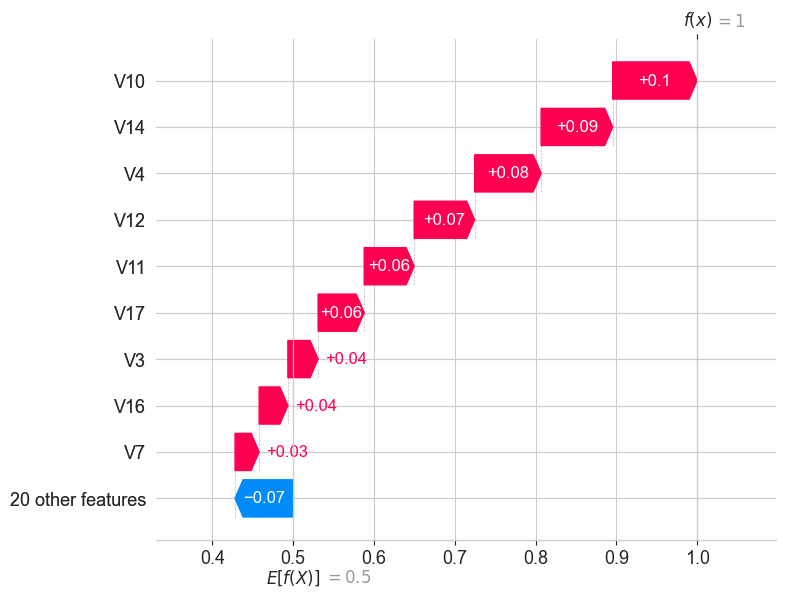

In [ ]:
# ====================================================================
# CASO 1: VERDADERO POSITIVO (Fraude bien detectado)
# ====================================================================
# Se elige una instancia de fraude que el modelo clasificó correctamente con alta confianza.
# Se busca el fraude con la probabilidad más alta predicha por el modelo.

tp_instance_index = results_df.loc[tp_indices, 'y_pred_proba'].idxmax()
print(f"Analizando Verdadero Positivo - Índice: {tp_instance_index}")
#print(f"Probabilidad de la observación en cuestión: {results_df.loc[tp_instance_index, 'y_pred_proba']}")

# Generar el gráfico de cascada.
shap.waterfall_plot( 
    shap.Explanation( 
        values=shap_values[X_test.index.get_loc(tp_instance_index), :, 1], 
        base_values=explainer.expected_value[1], 
        feature_names=X_test.columns 
    ) 
) 

En este primer caso, es un Verdadero Positivo que tiene la más alta probabilidad de fraude (tomando en consideración el código). En el gráfico se muestran las características que más contribuyeron a la alta probabilidad de fraude. Features como V10, V14, V4 y V12 (valores en rojo) incrementan fuertemente la predicción hacia la derecha (Fraude), superando el efecto de otras características que sugeieren que se trate de otro tipo de predicción.

Analizando Verdadero Negativo - Índice: 263020


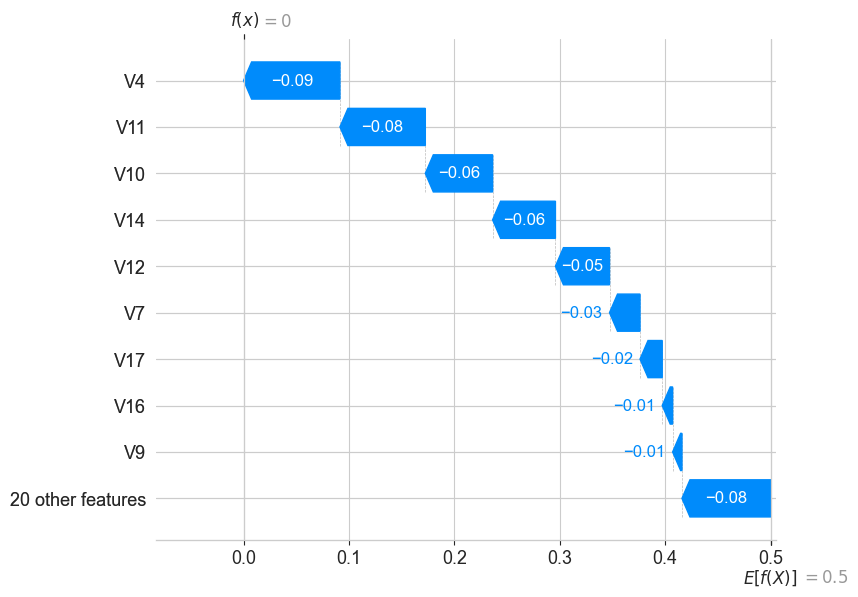

In [16]:
# ====================================================================
# CASO 2: VERDADERO NEGATIVO (No Fraude bien detectado)
# ====================================================================
# Se elige una instancia normal que el modelo clasificó correctamente con alta confianza (baja prob de fraude).
# Se busca la transacción normal con la probabilidad de fraude más baja.

tn_instance_index = results_df.loc[tn_indices, 'y_pred_proba'].idxmin()
print(f"Analizando Verdadero Negativo - Índice: {tn_instance_index}")

# Generar el gráfico de cascada.
shap.waterfall_plot( 
    shap.Explanation( 
        values=shap_values[X_test.index.get_loc(tn_instance_index), :, 1], 
        base_values=explainer.expected_value[1], 
        feature_names=X_test.columns 
    ) 
) 

Revisemos la interpretación del Verdadero Negativo en cuestión. Aquí vemos el caso opuesto al caso anterior. Las características más importantes (como V4, V11, V10) tienen valores (en azul) que impulsan la predicción fuertemente hacia la izquierda, confirmando que la transacción es legítima.

Analizando Falso Positivo - Índice: 16110


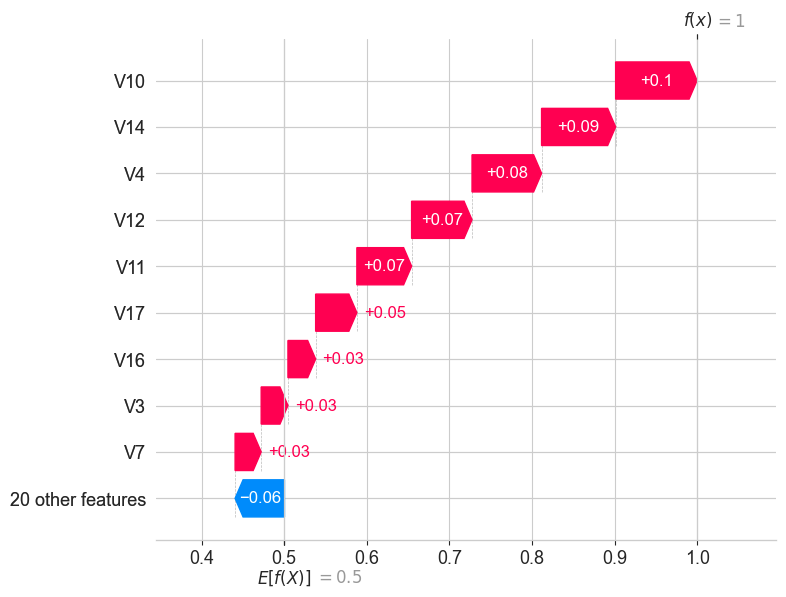

In [17]:
# ====================================================================
# CASO 3: FALSO POSITIVO (Alerta de fraude incorrecta)
# ====================================================================
# Este es un caso de diagnóstico crucial. ¿Por qué el modelo se equivocó?
# Se elige la alerta de fraude incorrecta con la probabilidad más alta.

fp_instance_index = results_df.loc[fp_indices, 'y_pred_proba'].idxmax()
print(f"Analizando Falso Positivo - Índice: {fp_instance_index}")

# Generar el gráfico de cascada.
shap.waterfall_plot( 
    shap.Explanation( 
        values=shap_values[X_test.index.get_loc(fp_instance_index), :, 1], 
        base_values=explainer.expected_value[1], 
        feature_names=X_test.columns 
    ) 
) 

Para el registro de un caso del Falso Positivo, podemos observar que este análisis es clave para mejorar el modelo. El gráfico revela que, a pesar de ser una transacción legítima, tenía valores en ciertas features (ej. V10, V14) que se asemejan a los patrones de fraude que el modelo ha aprendido. Esto sugiere que el modelo podría estar generalizando en exceso en base a estas features. El siguiente paso sería analizar un grupo de Falsos Positivos para buscar patrones comunes.

Analizando Falso Negativo - Índice: 157585


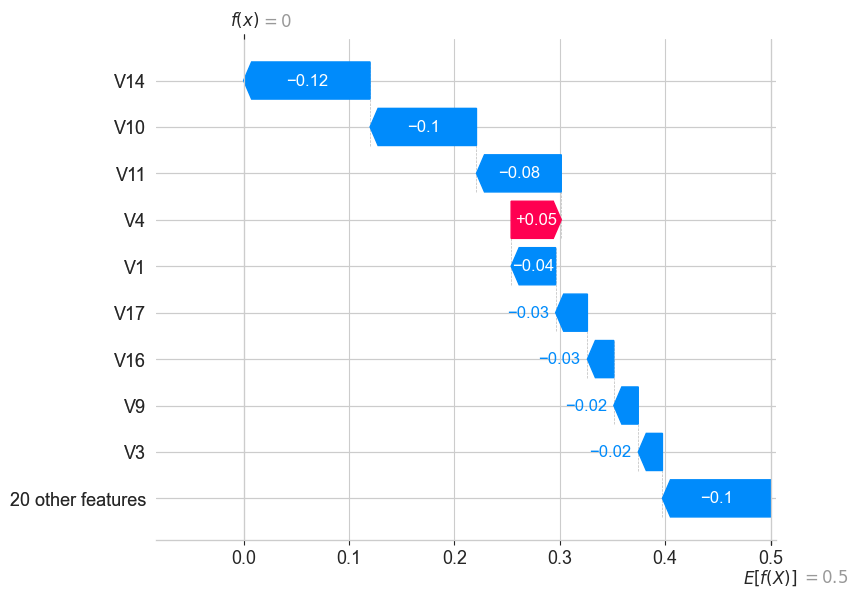

In [18]:
# ====================================================================
# CASO 4: FALSO NEGATIVO (Fraude no detectado)
# ====================================================================
# Este es el error más costoso. ¿Por qué el modelo no detectó este fraude?
# Se elige el fraude no detectado con la probabilidad de fraude más baja.

fn_instance_index = results_df.loc[fn_indices, 'y_pred_proba'].idxmin()
print(f"Analizando Falso Negativo - Índice: {fn_instance_index}")

# Generar el gráfico de cascada.
shap.waterfall_plot( 
    shap.Explanation( 
        values=shap_values[X_test.index.get_loc(fn_instance_index), :, 1], 
        base_values=explainer.expected_value[1], 
        feature_names=X_test.columns 
    ) 
)

Observemos este registro de un Falso Negativo. Este es el caso más peligroso. A pesar de ser un fraude, las features de esta transacción no activaron las 'alarmas' del modelo. De hecho, la mayoría de las features empujaron la predicción hacia 'No Fraude'. Esto podría indicar un nuevo tipo de fraude que el modelo no ha visto antes, o una instancia de fraude muy sofisticada que imita el comportamiento normal. Analizar estos casos es fundamental para identificar las debilidades del modelo.

Analizando Predicción Límite - Índice: 153398


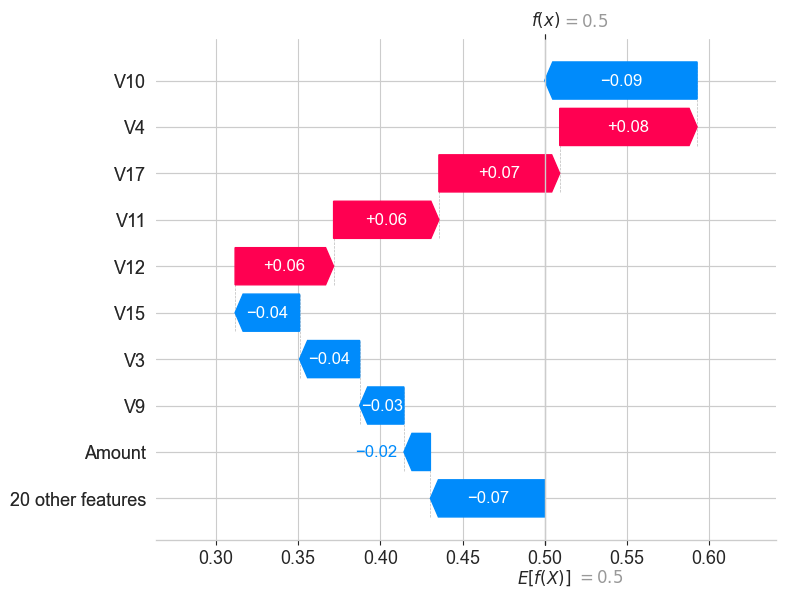

In [19]:
# ====================================================================
# CASO 5: PREDICCIÓN LÍMITE (Incertidumbre del modelo)
# ====================================================================
# Se elige una instancia cuya probabilidad predicha está muy cerca del umbral de decisión (0.5).
# Esto nos muestra en qué casos el modelo tiene más dudas.

borderline_index = (results_df['y_pred_proba'] - 0.5).abs().idxmin()
print(f"Analizando Predicción Límite - Índice: {borderline_index}")

# Generar el gráfico de cascada.
shap.waterfall_plot( 
    shap.Explanation( 
        values=shap_values[X_test.index.get_loc(borderline_index), :, 1], 
        base_values=explainer.expected_value[1], 
        feature_names=X_test.columns 
    ) 
)

En este último caso analizamos un caso que queda justo o muy cerca del umbral de decisión del modelo. En esta transacción, vemos una 'lucha' entre las características. Algunas (como V4 y V11) empujan la predicción hacia una transacción fraudulenta, mientras que otras (como V10 y V15) la empujan fuertemente hacia una transacción normal. El resultado final es una predicción muy cercana al umbral, lo que indica que el modelo no tiene una alta confianza en su decisión. Estos son casos que podrían merecer una revisión manual por parte de un analista.